In [1]:
from sirf.STIR import AcquisitionData, ImageData
from sirf.Reg import NiftyResample
from cil.framework import BlockDataContainer
from cil.optimisation.operators import BlockOperator, ZeroOperator, GradientOperator
from cil.optimisation.functions import WeightedL2NormSquared, MixedL21Norm
from cil_extensions.BDC_Indicator import IndicatorBox
from cil_extensions.PD3O import PD3O
from VectorialTotalVariation.VTV import SimpleVTV

import matplotlib.pyplot as plt

import cProfile, pstats, io
from pstats import SortKey

pr = cProfile.Profile()

In [2]:
def resample_image(image, reference, interp = 1):
    res = NiftyResample()
    res.set_reference_image(reference)
    res.set_floating_image(image)
    res.set_interpolation_type(interp)
    return res.forward(image)  

In [3]:
sino = AcquisitionData("/home/sam/data/phantom_data/PET/projdata_bed0.hs")
additive = AcquisitionData("/home/sam/data/phantom_data/PET/additive3d_bed0_nonan.hs")
norm_sino =  AcquisitionData("/home/sam/data/phantom_data/PET/inv_normacfprojdata_bed0.hs")
umap = ImageData("/home/sam/data/phantom_data/PET/umap_zoomed.hv")
spect = ImageData("/home/sam/data/phantom_data/PET/spect4.hv")

init_image = sino.create_uniform_image(1, xy=(28,28))
if umap.shape != init_image.shape:
    umap = resample_image(umap, init_image)
if spect.shape != init_image.shape:
    spect = resample_image(spect, init_image)










Scanner parameters:= 
Scanner type := Userdefined
Number of rings                          := 38
Number of detectors per ring             := 648
Inner ring diameter (cm)                 := 84.8
Average depth of interaction (cm)        := 0.6
Distance between rings (cm)              := 0.39
Default bin size (cm)                    := 0.39
View offset (degrees)                    := -92.5
Maximum number of non-arc-corrected bins := 351
Default number of arc-corrected bins     := 351
Energy resolution := 0.1
Reference energy (in keV) := 511
Number of blocks per bucket in transaxial direction         := 1
Number of blocks per bucket in axial direction              := 1
Number of crystals per block in axial direction             := 38
Number of crystals per block in transaxial direction        := 27
Number of detector layers                                   := 1
Number of crystals per singles unit in axial direction      := 38
Number of crystals per singles unit in transaxial dire


INFO: Determined voxel size by dividing default_bin_size (3.9) by zoom

No transformations set, using identity.

No transformations set, using identity.


In [4]:
bdc = BlockDataContainer(umap, umap, spect)
indic = IndicatorBox(lower=0)
grad = GradientOperator(init_image)

zero = ZeroOperator(init_image, grad.range_geometry())
jac = BlockOperator(grad, zero, zero,
                zero, grad, zero,
                zero, zero, grad, shape = (3,3))

vtv = SimpleVTV(bdc)
l21 = MixedL21Norm()

In [5]:
def inv_operator_proximal(image, operator, norm, func, tau, add=None):

    tmp_dir = operator.direct(image) 
    
    tmp = func.proximal(tmp_dir, tau*norm) - tmp_dir

    return image + 1/norm * operator.adjoint(tmp)

In [35]:
adj_dir = jac.adjoint(jac.direct(bdc))
adj_dir[0].max()

0.012976945

You may need to close Figures' 1 - 5 windows to continue...


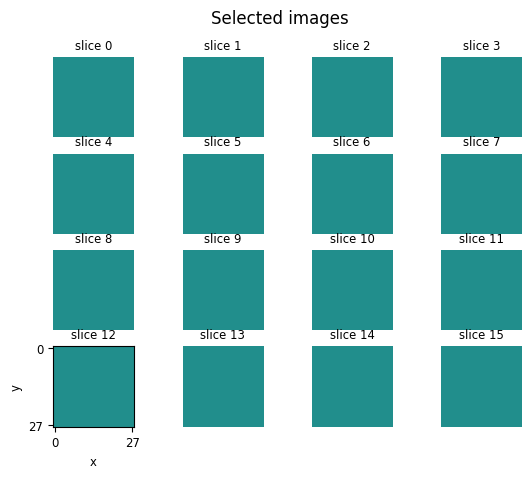

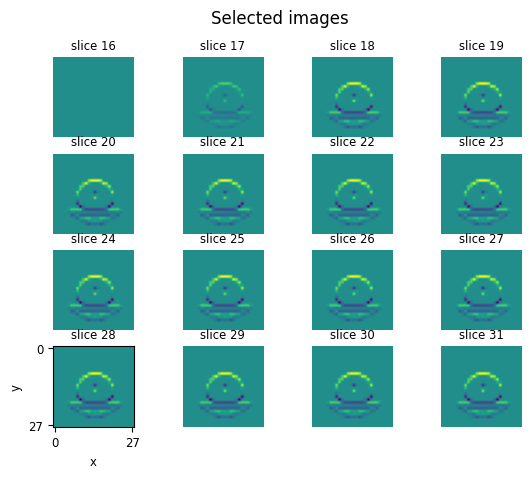

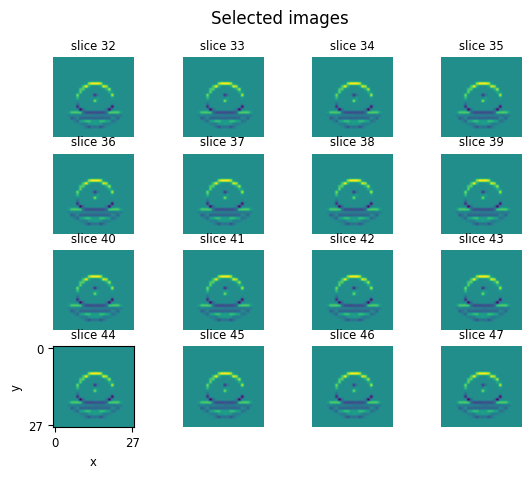

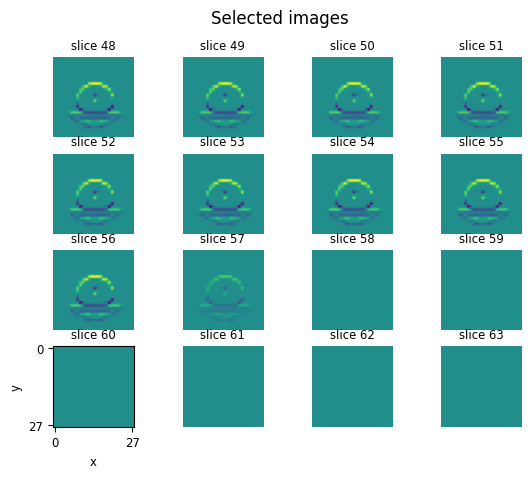

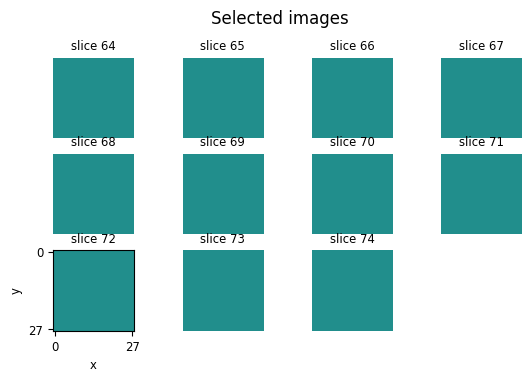

In [44]:
jac.direct(bdc)[0][1].show()

In [38]:
p = vtv.proximal(jac.direct(bdc),1)

You may need to close Figures' 1 - 5 windows to continue...


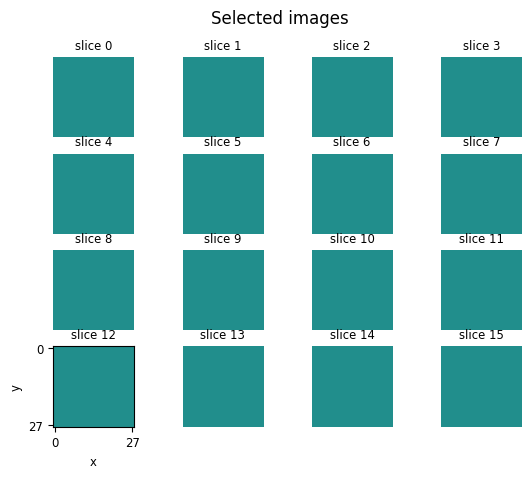

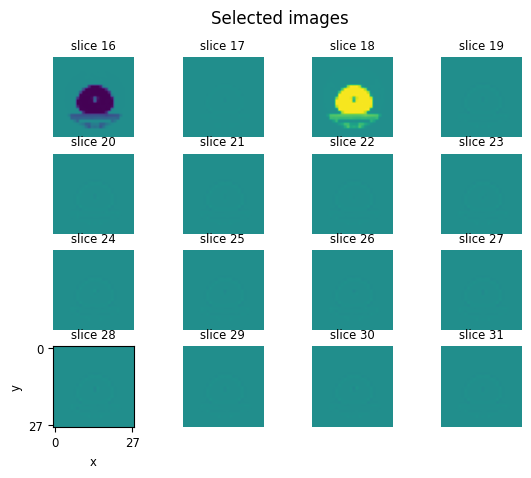

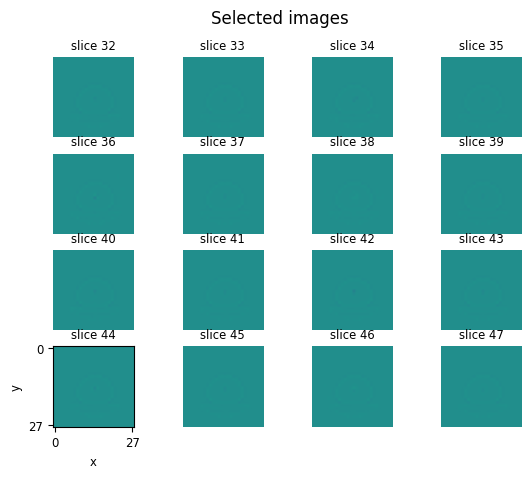

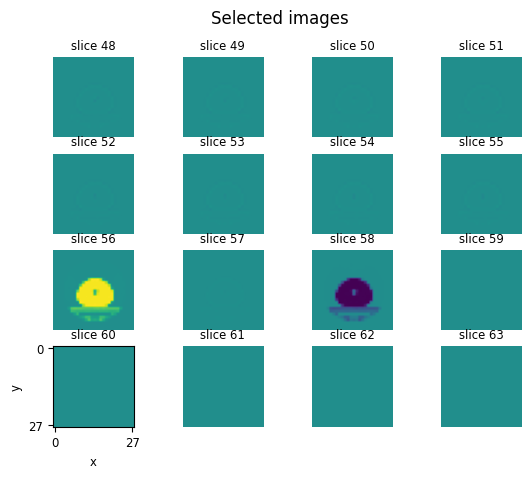

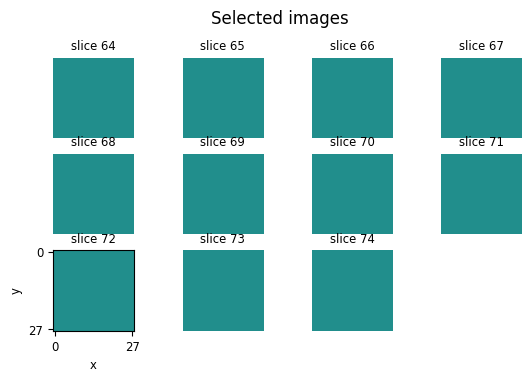

In [45]:
jac.adjoint(p)[1].show()

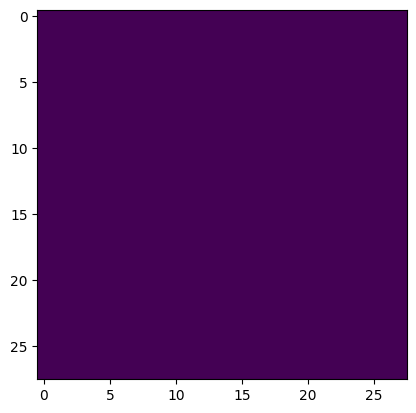

In [39]:
plt.imshow(jac.adjoint(p)[0].as_array()[32,:,:])

In [36]:
bdc[0].max()

0.09750882

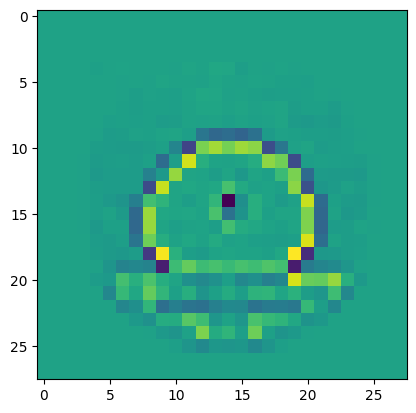

In [32]:
plt.imshow(adj_dir[0].as_array()[32])

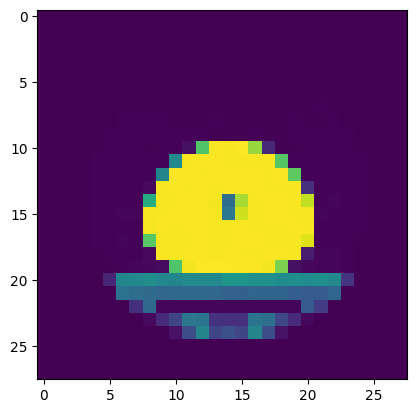

In [6]:
plt.imshow(bdc[1].as_array()[45])

In [7]:
prox = inv_operator_proximal(bdc, jac, 2, vtv, 1)

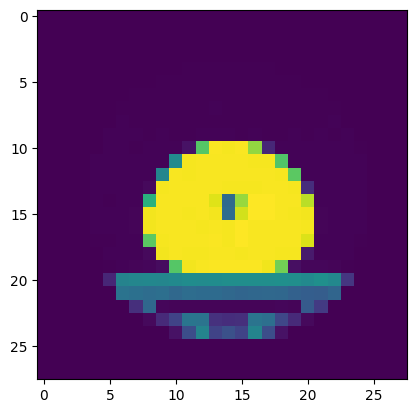

In [23]:
plt.imshow(prox[0].as_array()[32])

In [8]:
w = WeightedL2NormSquared(z = bdc, weights = 1/2)

In [28]:
pd3o = PD3O(f = w, g = indic, h = vtv, operator=jac, tau = 1/4, sigma = 1, max_iteration = 20, update_objective_interval = 1, initial=bdc)

In [29]:
pd3o.run(verbose = 2)

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0         20         0.000    2.68390e+03   2.48390e+03   0.00000e+00    1.99999e+02
Elapsed time for <function SimpleVTV.proximal_conjugate at 0x7fa5e3036200>: 0.3457 seconds
        1         20         3.083    2.67539e+03   2.47697e+03   0.00000e+00    1.98418e+02
Elapsed time for <function SimpleVTV.proximal_conjugate at 0x7fa5e3036200>: 0.3743 seconds
        2         20         3.030    1.51818e-04   7.41628e-11   0.00000e+00    1.51818e-04
Elapsed time for <function SimpleVTV.proximal_conjugate at 0x7fa5e3036200>: 0.3676 seconds
        3         20         3.054    7.05863e+00   6.56892e-02   0.00000e+00    6.99294e+00
Elapsed time for <function SimpleVTV.proximal_conjugate at 0x7fa5e3036200>: 0.3468 seconds
        4         20         3.061    7.05316e+00   1.28323e-01   0.00000e+00    6.92484e+00
Elapsed time 

In [11]:
w2 = WeightedL2NormSquared(z = bdc[0], weights = 1/2)

In [12]:
grad.norm()

1.0149677203828649

In [27]:
pd3o2 = PD3O(f = w2, g = indic, h = l21, operator=grad, tau = 1/4, sigma = 1, max_iteration = 20, update_objective_interval = 1, initial=bdc[0])

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0         20         0.000    6.18706e+01   3.95176e+01   0.00000e+00    2.23530e+01
        1         20         1.380    6.27356e+01   3.96639e+01   0.00000e+00    2.30716e+01
        2         20         1.267    0.00000e+00   0.00000e+00   0.00000e+00    0.00000e+00
        3         20         1.219    9.52805e-01   2.78655e-03   0.00000e+00    9.50018e-01
        4         20         1.213    2.14853e-03   1.42638e-08   0.00000e+00    2.14851e-03
        5         20         1.211    1.07567e+00   3.55181e-03   0.00000e+00    1.07212e+00
        6         20         1.212    4.85028e-03   7.27275e-08   0.00000e+00    4.85021e-03
        7         20         1.216    1.21468e+00   4.52753e-03   0.00000e+00    1.21016e+00
        8         20         1.211    8.21329e-03   2.08598e-07   0.00000e+00    8.21308e-03
     

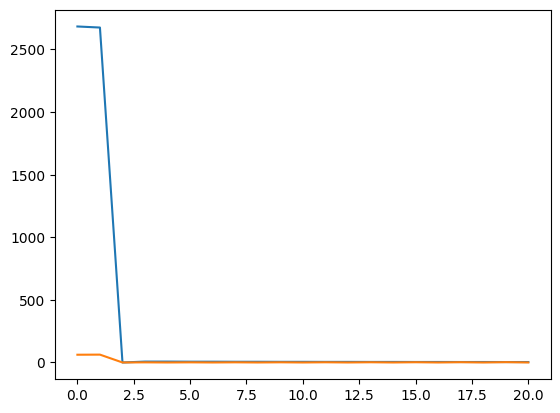

In [30]:
plt.plot(pd3o.objective)
plt.plot(pd3o2.objective)

In [ ]:
pd3o2.run(verbose=2)

In [15]:
def plot(fig, im, ax, title):
    im_0 = ax.imshow(im.as_array()[32, :, :])
    ax.set_title(title)
    fig.colorbar(im_0, ax=ax)

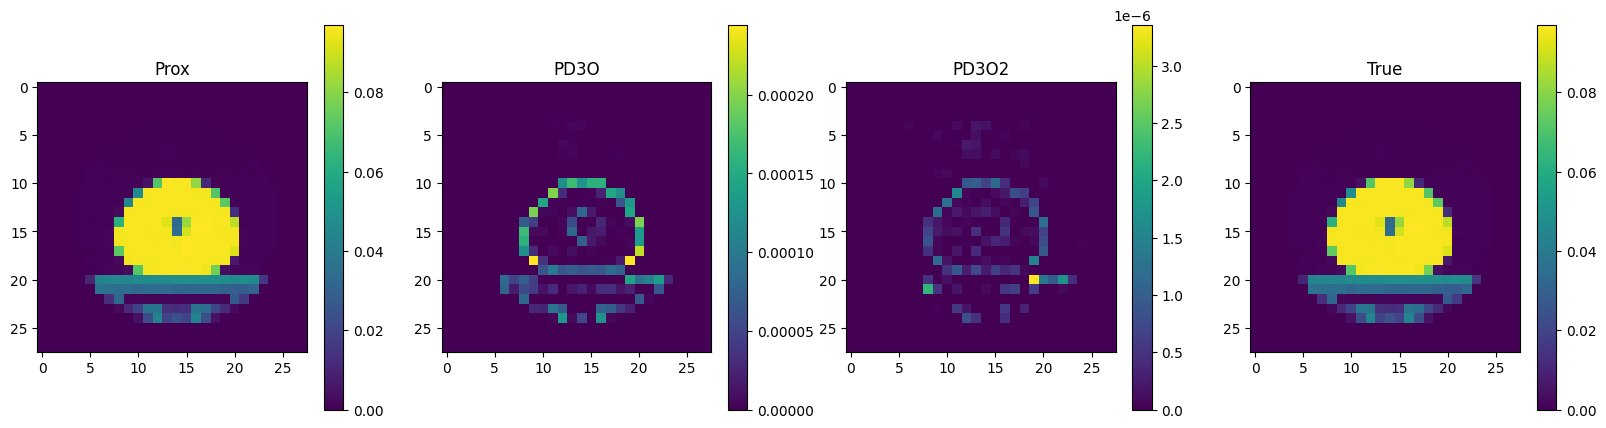

In [33]:
fig, ax = plt.subplots(1,4, figsize = (20,5))
plot(fig, prox[0], ax[0], "Prox")
plot(fig, pd3o.solution[0], ax[1], "PD3O")
plot(fig, pd3o2.solution, ax[2], "PD3O2")
plot(fig ,bdc[0], ax[3], "True")
